### <center> КРИТЕРИИ ОЦЕНКИ
- 0	Задание не выполнено
- 1	Обучено две модели; гипепараметры подобраны при помощи одного метода
- 2	Обучено две модели; гипепараметры подобраны при помощи двух методов
- 3	Обучено две модели; гипепараметры подобраны при помощи трёх методов
- 4	Обучено две модели; гипепараметры подобраны при помощи четырёх методов
- 5	Обучено две модели; гипепараметры подобраны при помощи четырёх методов; использована кросс-валидация

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import optuna
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import matplotlib.pyplot as plt

from scipy.stats import loguniform

RANDOM_STATE = 42

data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


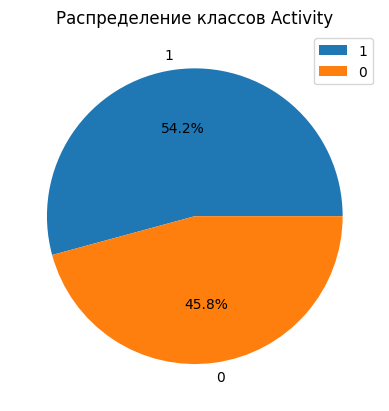

In [2]:
X = data.drop('Activity', axis=1)
y = data['Activity']

plt.pie(y.value_counts(normalize=True),
        labels=y.value_counts().index,
        autopct='%1.1f%%')

plt.title('Распределение классов Activity')
plt.legend();

Из визуализации видим, что соотношение примерно одинаковое, стратифицировать выборки не будем

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

## *Модель логистической регрессии*

In [4]:
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Посмотрим на метрику без оптимизации гиперпараметров: 

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

log_score_train_0 = round(f1_score(y_train, y_train_pred),3)
log_score_test_0 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {log_score_train_0}')
print(f'Модель выдает F1-score на тестовой выборке {log_score_test_0}')

Модель выдает F1-score на тренировочной выборке 0.885
Модель выдает F1-score на тестовой выборке 0.785


### *GridSearchCV*

In [6]:
param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 1, 100]
    },
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': [0.01, 1, 100, 1000]
    }
]

logistic_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)

grid_search = GridSearchCV(
            estimator=logistic_model,
            param_grid=param_grid,
            cv=5, # активируем кросс-валидацию
            n_jobs=-1)

grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

log_score_train_1 = round(f1_score(y_train, y_train_pred),3)
log_score_test_1 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {log_score_train_1}')
print(f'Модель выдает F1-score на тестовой выборке {log_score_test_1}')

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Модель выдает F1-score на тренировочной выборке 0.874
Модель выдает F1-score на тестовой выборке 0.781
Наилучшие значения гиперпараметров: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


### *RandomizedSearchCV* 

In [7]:
# Пространство гиперпараметров
param_distributions = {
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'penalty': ['l1', 'l2'], 
    'C': loguniform(1e-4, 1e4)  # Логарифмическое распределение для C
}

logistic_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)

random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=10,  # всего 10 случайных комбинаций
    cv=5,       # кросс валидация на 5 фолдов
    n_jobs=-1)

random_search.fit(X_train, y_train)

y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

log_score_train_2 = round(f1_score(y_train, y_train_pred),3)
log_score_test_2 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {log_score_train_2}')
print(f'Модель выдает F1-score на тестовой выборке {log_score_test_2}')

print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))


Модель выдает F1-score на тренировочной выборке 0.845
Модель выдает F1-score на тестовой выборке 0.792
Наилучшие значения гиперпараметров: {'C': 0.06014971666566227, 'penalty': 'l2', 'solver': 'lbfgs'}


### *Hyperopt*

In [8]:
# создадим простаранство гиперпараметров

space = {
    'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'saga']),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -4, 4),  # эквивалентно диапазону от ~0.018 до ~54.6
}

In [9]:
def hyperopt_log_reg(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'solver': params['solver'], 
              'penalty': params['penalty'],
              'C': params['C']
              }
  
    # Создадим словарь с допустимыми penalty для каждого solver
    correct_penalties = {
        'lbfgs': ['l2'],
        'newton-cg': ['l2'],
        'saga': ['l1', 'l2'],
        'liblinear': ['l1', 'l2']
    }
    
    # штрафуем недопустимую комбинацию максимальным значением
    if params['penalty'] not in correct_penalties.get(params['solver'], []):
        return 1  

    logistic_model = LogisticRegression(**params,
                                        random_state=RANDOM_STATE,
                                        max_iter=200)
    
    # Обучаем модель на кросс валидации и сразу считаем score
    score = cross_val_score(logistic_model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [10]:
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_log_reg, # наша функция 
          space=space, # пространство гиперпараметров
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate = np.random.default_rng(RANDOM_STATE))

print("Наилучшие значения гиперпараметров {}".format(best))

TPE is being used as the default algorithm.


100%|██████████| 10/10 [02:02<00:00, 12.29s/trial, best loss: -0.7854601824470312]
Наилучшие значения гиперпараметров {'C': 0.06641667456492358, 'penalty': 1, 'solver': 2}


In [11]:
# Поскольку в словаре best для penalty и solver хранятся именно индексы, то придется немного заморочиться

solver_options = ['liblinear', 'lbfgs', 'saga']
penalty_options = ['l1', 'l2']

solver = solver_options[best['solver']]  
penalty = penalty_options[best['penalty']] 

# рассчитаем F1 для тренировочной и тестовой выборок
logistic_model = LogisticRegression(
    random_state = RANDOM_STATE, 
    solver = solver,
    penalty = penalty,
    C = float(best['C']),
    max_iter=200)

logistic_model.fit(X_train, y_train)

y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

log_score_train_3 = round(f1_score(y_train, y_train_pred),3)
log_score_test_3 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {log_score_train_3}')
print(f'Модель выдает F1-score на тестовой выборке {log_score_test_3}')

Модель выдает F1-score на тренировочной выборке 0.845
Модель выдает F1-score на тестовой выборке 0.793


### *Optuna*

In [12]:
def optuna_log_reg(trial, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    
    # задаем пространства поиска гиперпараметров
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-4, 1e4, log=True) # эквивалентно диапазону от ~0.018 до ~54.6

    # Создадим словарь с допустимыми penalty для каждого solver
    correct_penalties = {
        'lbfgs': ['l2'],
        'newton-cg': ['l2'],
        'saga': ['l1', 'l2'],
        'liblinear': ['l1', 'l2']
    }
    
    # Возвращаем плохое значение, чтобы Optuna не выбирал эту комбинацию
    if penalty not in correct_penalties.get(solver, []):
        return - 1

    logistic_model = LogisticRegression(solver=solver,
                                        penalty=penalty,
                                        random_state=RANDOM_STATE,
                                        max_iter=200)
        
    # Обучаем модель на кросс валидации и сразу считаем score
    score = cross_val_score(logistic_model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return score
  

In [13]:
# cоздаем объект исследования
study = optuna.create_study(study_name='LogisticRegression', direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_log_reg, n_trials=10)
print('-'*40)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2025-07-02 19:14:58,926] A new study created in memory with name: LogisticRegression
[I 2025-07-02 19:14:58,926] Trial 0 finished with value: -1.0 and parameters: {'solver': 'lbfgs', 'penalty': 'l1', 'C': 22.171976287605283}. Best is trial 0 with value: -1.0.
[I 2025-07-02 19:15:00,042] Trial 1 finished with value: 0.7714512595300139 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 30.274567319298715}. Best is trial 1 with value: 0.7714512595300139.
[I 2025-07-02 19:15:01,176] Trial 2 finished with value: 0.7714512595300139 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.00013709022241741736}. Best is trial 1 with value: 0.7714512595300139.
[I 2025-07-02 19:15:22,017] Trial 3 finished with value: 0.780742572778411 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.09919077478263028}. Best is trial 3 with value: 0.780742572778411.
[I 2025-07-02 19:15:22,019] Trial 4 finished with value: -1.0 and parameters: {'solver': 'lbfgs', 'penalty': 'l1', 'C'

----------------------------------------
Наилучшие значения гиперпараметров {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.011653135355796283}


In [14]:
# рассчитаем точность для тренировочной и тестовой выборок
logistic_model = LogisticRegression(
            **study.best_params,
            random_state = RANDOM_STATE,
            max_iter=200)

logistic_model.fit(X_train, y_train)

y_train_pred = logistic_model.predict(X_train)
y_test_pred = logistic_model.predict(X_test)

log_score_train_4 = round(f1_score(y_train, y_train_pred),3)
log_score_test_4 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {log_score_train_4}')
print(f'Модель выдает F1-score на тестовой выборке {log_score_test_4}')

Модель выдает F1-score на тренировочной выборке 0.748
Модель выдает F1-score на тестовой выборке 0.771


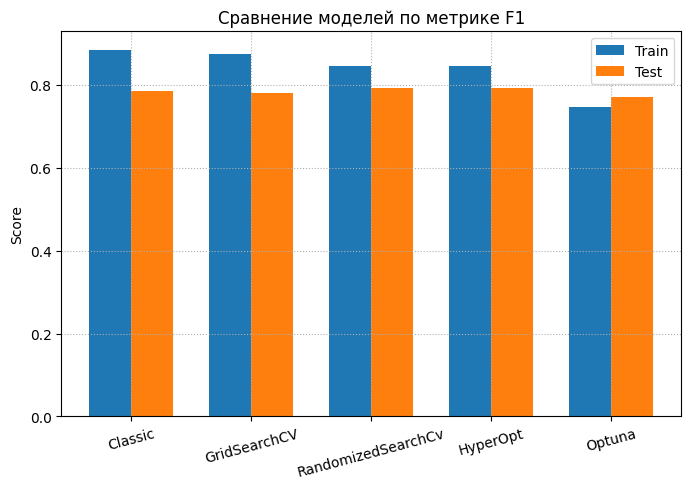

In [15]:
# Визуализируем полученные результаты

models = ['Classic', 'GridSearchCV', 'RandomizedSearchCv', 'HyperOpt', 'Optuna']
train_scores = [log_score_train_0, log_score_train_1, log_score_train_2, log_score_train_3, log_score_train_4]
test_scores = [log_score_test_0, log_score_test_1, log_score_test_2, log_score_test_3, log_score_test_4]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width/2, train_scores, width, label='Train')
ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Сравнение моделей по метрике F1')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.xaxis.set_tick_params(rotation = 15)
ax.grid(linestyle=':');

Как это и неудивительно, на тестовой выборке победителем в нашей номинации становится метод *RandomizedSearchCv*.
Видно, что для мощного метода *Optuna* банально не хватило итераций (было сделано 10 штук, с учетом 5 фолдов кроссвалидации получается 50) - модель даже на трейне выдает самый худший результат.

## *Модель случайного леса*

In [16]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

y_train_pred = forest_model.predict(X_train)
y_test_pred = forest_model.predict(X_test)

for_score_train_0 = round(f1_score(y_train, y_train_pred),3)
for_score_test_0 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {for_score_train_0}')
print(f'Модель выдает F1-score на тестовой выборке {for_score_test_0}')

Модель выдает F1-score на тренировочной выборке 1.0
Модель выдает F1-score на тестовой выборке 0.832


### *GridSearchCV*

In [17]:
param_grid = {'min_samples_leaf': [5, 7], 'max_depth': [10, 13, 18, 21, 25]}

forest_model = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search = GridSearchCV(
            estimator=forest_model,
            param_grid=param_grid,
            cv=5, # активируем кросс-валидацию
            n_jobs=-1)

grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

for_score_train_1= round(f1_score(y_train, y_train_pred),3)
for_score_test_1 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {for_score_train_1}')
print(f'Модель выдает F1-score на тестовой выборке {for_score_test_1}')

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Модель выдает F1-score на тренировочной выборке 0.943
Модель выдает F1-score на тестовой выборке 0.834
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 5}


### *RandomizedSearchCV* 

In [18]:
param_distributions = {
    'min_samples_leaf': [2, 4, 6, 8, 10],           
    'max_depth': [10, 13, 15, 18, 21, 25], 
    'min_samples_split': [2, 5, 10],             
    'n_estimators': [50, 100, 200, 300],         
    'max_features': ['sqrt', 'log2']     
}


forest_model = RandomForestClassifier(random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
            estimator=forest_model,
            param_distributions=param_distributions,
            n_iter=10,  # всего 10 случайных комбинаций
            cv=5,       # кросс валидация на 5 фолдов
            n_jobs=-1)

random_search.fit(X_train, y_train) 

y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

for_score_train_2= round(f1_score(y_train, y_train_pred),3)
for_score_test_2 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {for_score_train_2}')
print(f'Модель выдает F1-score на тестовой выборке {for_score_test_2}')

print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Модель выдает F1-score на тренировочной выборке 0.987
Модель выдает F1-score на тестовой выборке 0.826
Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 25}


### *Hyperopt*

In [19]:
# Создадим простанство гиперпараметров

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),           # количество деревьев, от 50 до 500 с шагом 10
    'max_depth': hp.quniform('max_depth', 5, 50, 1),                    # максимальная глубина дерева
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),    # минимальное число объектов для разбиения узла
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),      # минимальное число объектов в листе
    'max_features': hp.choice('max_features', ['sqrt', 'log2']) # число признаков для разбиения
}

In [20]:
def hyperopt_forest(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    
    # функция получает комбинацию гиперпараметров в "params"
    params =   {'n_estimators': int(params['n_estimators']),
                'max_depth': int(params['max_depth']),
                'min_samples_split': int(params['min_samples_split']),
                'min_samples_leaf': int(params['min_samples_leaf']),
                'max_features': params['max_features']
    }

  
    forest_model = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    # Обучаем модель на кросс валидации и сразу считаем score
    score = cross_val_score(forest_model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [21]:
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_forest, # наша функция 
            space=space, # пространство гиперпараметров
            max_evals=10, # максимальное количество итераций
            trials=trials, # логирование результатов
            rstate = np.random.default_rng(RANDOM_STATE))

print("Наилучшие значения гиперпараметров {}".format(best))

TPE is being used as the default algorithm.


100%|██████████| 10/10 [00:37<00:00,  3.79s/trial, best loss: -0.8085522567240029]
Наилучшие значения гиперпараметров {'max_depth': 50.0, 'max_features': 0, 'min_samples_leaf': 1.0, 'min_samples_split': 16.0, 'n_estimators': 380.0}


In [22]:
# рассчитаем F1 для тренировочной и тестовой выборок
forest_model = RandomForestClassifier(
        random_state = RANDOM_STATE, 
        max_depth=int(best['max_depth']),
        max_features='sqrt',
        min_samples_leaf=int(best['min_samples_leaf']),
        min_samples_split=int(best['min_samples_split']), 
        n_estimators=int(best['n_estimators'])
        )
        
forest_model.fit(X_train, y_train)

y_train_pred = forest_model.predict(X_train)
y_test_pred = forest_model.predict(X_test)

for_score_train_3 = round(f1_score(y_train, y_train_pred),3)
for_score_test_3 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {for_score_train_3}')
print(f'Модель выдает F1-score на тестовой выборке {for_score_test_3}')

Модель выдает F1-score на тренировочной выборке 0.962
Модель выдает F1-score на тестовой выборке 0.834


### *Optuna*

In [23]:
def optuna_forest(trial, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    
    # задаем пространства поиска гиперпараметров
    
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
  

    forest_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=RANDOM_STATE
    )
        
    # Обучаем модель на кросс валидации и сразу считаем score
    score = cross_val_score(forest_model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return score

In [24]:
# cоздаем объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_forest, n_trials=10)
print('-'*40)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2025-07-02 19:16:50,393] A new study created in memory with name: RandomForestClassifier
[I 2025-07-02 19:16:51,984] Trial 0 finished with value: 0.7810060065939828 and parameters: {'n_estimators': 210, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7810060065939828.
[I 2025-07-02 19:16:55,167] Trial 1 finished with value: 0.7938869908693559 and parameters: {'n_estimators': 420, 'max_depth': 49, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.7938869908693559.
[I 2025-07-02 19:16:55,801] Trial 2 finished with value: 0.7822119577706357 and parameters: {'n_estimators': 50, 'max_depth': 38, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.7938869908693559.
[I 2025-07-02 19:16:57,467] Trial 3 finished with value: 0.7684755910761641 and parameters: {'n_estimators': 250, 'max_depth': 19, 'min_samples_split': 1

----------------------------------------
Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [25]:
# рассчитаем точность для тренировочной и тестовой выборок
forest_modelmodel = RandomForestClassifier(
            **study.best_params,
            random_state = RANDOM_STATE)

forest_model.fit(X_train, y_train)

y_train_pred = forest_model.predict(X_train)
y_test_pred = forest_model.predict(X_test)

for_score_train_4 = round(f1_score(y_train, y_train_pred),3)
for_score_test_4 = round(f1_score(y_test, y_test_pred), 3)

print(f'Модель выдает F1-score на тренировочной выборке {for_score_train_4}')
print(f'Модель выдает F1-score на тестовой выборке {for_score_test_4}')

Модель выдает F1-score на тренировочной выборке 0.962
Модель выдает F1-score на тестовой выборке 0.834


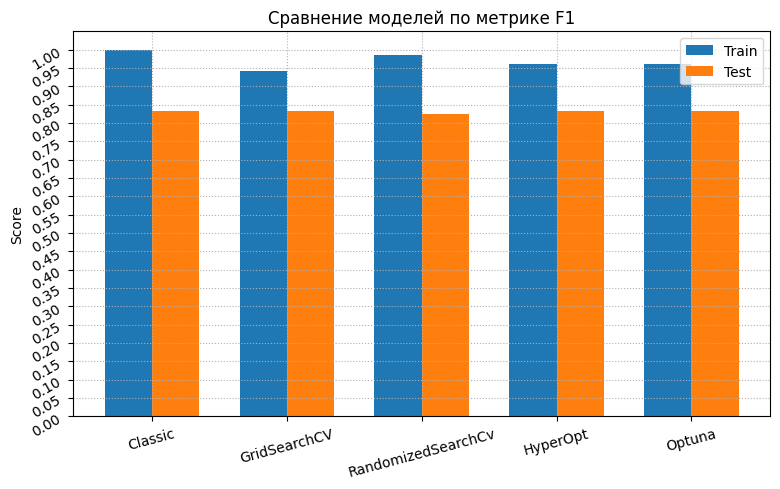

In [26]:
# Визуализируем полученные результаты

models = ['Classic', 'GridSearchCV', 'RandomizedSearchCv', 'HyperOpt', 'Optuna']
train_scores = [for_score_train_0, for_score_train_1, for_score_train_2, for_score_train_3, for_score_train_4]
test_scores = [for_score_test_0, for_score_test_1, for_score_test_2, for_score_test_3, for_score_test_4]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(9,5))

ax.bar(x - width/2, train_scores, width, label='Train')
ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Сравнение моделей по метрике F1')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.xaxis.set_tick_params(rotation = 15)
ax.yaxis.set_tick_params(rotation = 30)
ax.set_yticks(np.arange(0, 1.01, 0.05))
ax.grid(linestyle=':');

И вновь продвинутые методы оптимизации остались за бортом. На этот раз победителем стал *GridSearchCV*.
Вероятно, если бы мы не использовали кросс-валидацию и за счет этого увеличили бы *max_evals* и *n_trials*, продвинутые модели показали бы результат получше.

В целом видно, что с данной задачей лучше справляется модель случайного леса - метрики значительно выше, что у логистической регрессии. Но также несмотря на высокие значения метрик на тесте, видно что модели получились довольно таки переобученные, поскольку метрики на трейне очень близки к 1.